
# Objective: To build meaningful classification model on the given dataset


# Dataset: Breast Cancer Wisconsin (Diagnostic) Dataset




In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm
import statistics
import matplotlib.pyplot as plt
from sklearn import metrics
from pandas import plotting
from scipy import stats
from sklearn import preprocessing
plt.style.use("ggplot")
import warnings
import itertools
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Input & Preprocessing

In [ ]:
# keep the file 'breast-cancer-wisconsin.csv' in the same directory where the script is

data = pd.read_csv('breast-cancer-wisconsin.csv', na_values='?')
headers = ["ID","Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape","Marginal Adhesion","Single Epithelial Cell Size","Number of Bare Nuclei","Bland Chromatin","Number of Normal Nuclei","Mitosis","Diagnosis"]
data.columns = headers
del data['ID']
print(data['Diagnosis'].value_counts(),"\n")
print("2 -> Benign, 4 -> Malignant")

2    458
4    241
Name: Diagnosis, dtype: int64 

2 -> Benign, 4 -> Malignant


In [ ]:
original_data = data.copy()

original_data.iloc[:,9].replace(2, 'Benign',inplace=True)
original_data.iloc[:,9].replace(4, 'Malignant',inplace=True)

original_data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Number of Bare Nuclei,Bland Chromatin,Number of Normal Nuclei,Mitosis,Diagnosis
0,5,1,1.0,1,2.0,1.0,3,1,1,Benign
1,5,4,4.0,5,7.0,10.0,3,2,1,Benign
2,3,1,1.0,1,2.0,2.0,3,1,1,Benign
3,6,8,8.0,1,3.0,4.0,3,7,1,Benign
4,4,1,1.0,3,2.0,1.0,3,1,1,Benign


In [ ]:
data.iloc[:,9].replace(2, 1,inplace=True)
data.iloc[:,9].replace(4, 0,inplace=True)

# MISSING DATA ANALYSIS


### Missing data points are those having "?" or "NaN" in place of the data values 


In [ ]:
#Is there missing data?
if data.isnull().values.any():
  print("There are missing values in the data.")
print("The total number of missing values are: ", data.isnull().sum().sum())
print("The missing data points are:")
data.isnull().sum()

There are missing values in the data.
The total number of missing values are:  18
The missing data points are:


Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        1
Marginal Adhesion               0
Single Epithelial Cell Size     1
Number of Bare Nuclei          16
Bland Chromatin                 0
Number of Normal Nuclei         0
Mitosis                         0
Diagnosis                       0
dtype: int64

### Can we afford to remove data points?


---


> When there are missing values in the dataset, one way of handling these missing values is to delete that particular record consisting of missing values. However, the removal of data points should only be practiced when the dataset is huge, i.e., it consists of millions of records. 

> Since, the dataset used in this project is small, hence, removal of data points could not be afforded. This is because every record in such datasets specifies a huge amount of information which in turns helps the model to learn more about that dataset.









### Do we use imputation (and introduce additional uncertainty)?


---


> The imputation technique can be used for replacing the missing values. This is done in order to improve the decision making. 


> The technique of imputation introduces additional uncertainity. That is the reaseon why a balanced imputation is required. 





#Feature Engineering

## Visualization

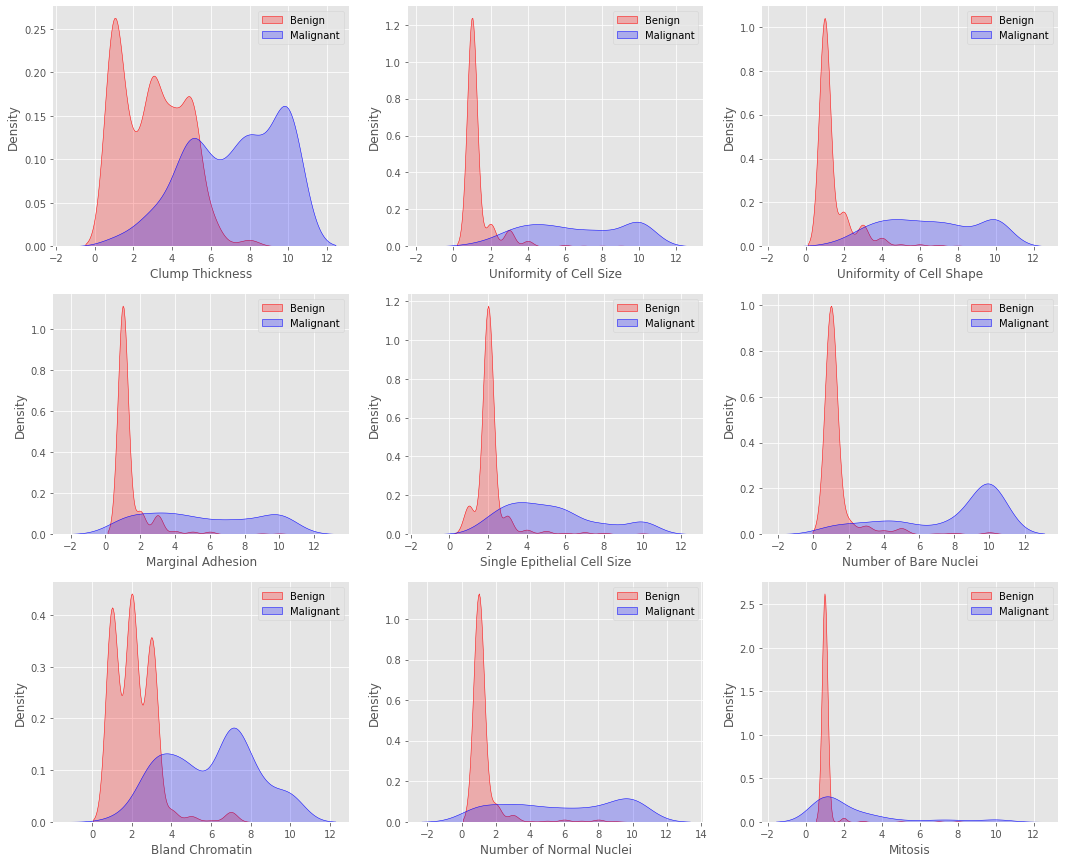

In [ ]:
list_of_features = data.drop(['Diagnosis'],axis=1).columns.tolist()
#Set up of the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(18, 15))
sns.despine(left=True)

a = data[data['Diagnosis']==1]
b = data[data['Diagnosis']==0]

for i in range(0,len(list_of_features)):
    y=i%3;
    x=int(i/3)
    sns.distplot(a[list_of_features[i]],  hist=False, color="r", kde_kws={"shade": True}, ax=axes[x, y],label='Benign')
    sns.distplot(b[list_of_features[i]],  hist=False, color="b", kde_kws={"shade": True}, ax=axes[x, y],label='Malignant')
    axes[x,y].legend()
plt.show() 

In [ ]:
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Number of Bare Nuclei,Bland Chromatin,Number of Normal Nuclei,Mitosis,Diagnosis
0,5,1,1.0,1,2.0,1.0,3,1,1,1
1,5,4,4.0,5,7.0,10.0,3,2,1,1
2,3,1,1.0,1,2.0,2.0,3,1,1,1
3,6,8,8.0,1,3.0,4.0,3,7,1,1
4,4,1,1.0,3,2.0,1.0,3,1,1,1


In [ ]:
#Scaling
y = data['Diagnosis']
data = data.drop(columns=['Diagnosis'])
dataset = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
dataset_scaled = min_max_scaler.fit_transform(dataset)
headers.remove("ID")
data = pd.DataFrame(dataset_scaled, columns=headers[:-1])
data['Diagnosis'] = y
data['Diagnosis'] = data['Diagnosis'].values.astype(np.int64)
data.head(5)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Number of Bare Nuclei,Bland Chromatin,Number of Normal Nuclei,Mitosis,Diagnosis
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0,1
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0,1
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0,1
3,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.0,1
4,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.0,1


In [ ]:
#Imputation 
temp = data[data.isna().any(axis=1)].index.tolist()
data['Number of Bare Nuclei'].fillna(data['Number of Bare Nuclei'].mean(),inplace=True)
data['Single Epithelial Cell Size'].fillna(data['Single Epithelial Cell Size'].mean(),inplace=True)
data['Uniformity of Cell Shape'].fillna(data['Uniformity of Cell Shape'].mean(),inplace=True)
data.iloc[temp] 

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Number of Bare Nuclei,Bland Chromatin,Number of Normal Nuclei,Mitosis,Diagnosis
23,0.777778,0.333333,0.444444,0.000000,0.111111,0.28274,0.666667,0.222222,0.0,0
40,0.555556,0.555556,0.555556,0.888889,0.555556,0.28274,0.666667,0.777778,0.0,1
139,0.000000,0.000000,0.000000,0.000000,0.000000,0.28274,0.111111,0.000000,0.0,1
145,0.000000,0.000000,0.222222,0.000000,0.111111,0.28274,0.111111,0.000000,0.0,1
158,0.000000,0.000000,0.111111,0.000000,0.222222,0.28274,0.000000,0.000000,0.0,1
164,0.444444,0.000000,0.000000,0.000000,0.111111,0.28274,0.222222,0.000000,0.0,1
235,0.222222,0.000000,0.333333,0.000000,0.111111,0.28274,0.222222,0.000000,0.0,1
249,0.222222,0.000000,0.000000,0.000000,0.111111,0.28274,0.222222,0.000000,0.0,1
275,0.222222,0.000000,0.222222,0.000000,0.111111,0.28274,0.111111,0.000000,0.0,1
292,0.777778,0.777778,0.777778,0.000000,0.111111,0.28274,0.555556,1.000000,0.0,0


In [ ]:
#Copy to visualise
visual_data = data.copy()
visual_data.iloc[:,9].replace(1, 'Benign',inplace=True)
visual_data.iloc[:,9].replace(0, 'Malignant',inplace=True)

boxplot


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

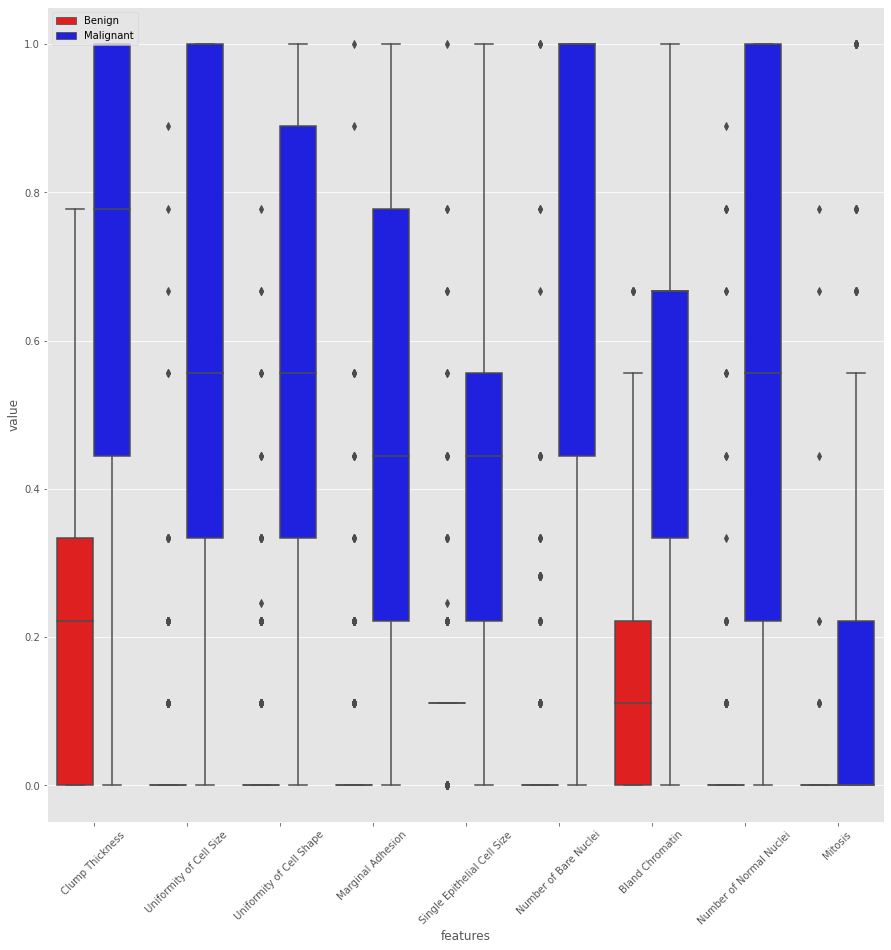

In [ ]:
#Visualizing Outliers 
data_box_plot = pd.melt(visual_data, "Diagnosis",
                    var_name="features") 

fig = plt.figure(figsize=(15,15))
print('boxplot')
my_pal = {'Benign':'r', 'Malignant':'b'}
sns.boxplot(x="features", y="value", hue="Diagnosis", data=data_box_plot, palette=my_pal)
plt.legend(loc='upper left') 
plt.xticks(rotation=45)
# plt.show()

violinplot


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

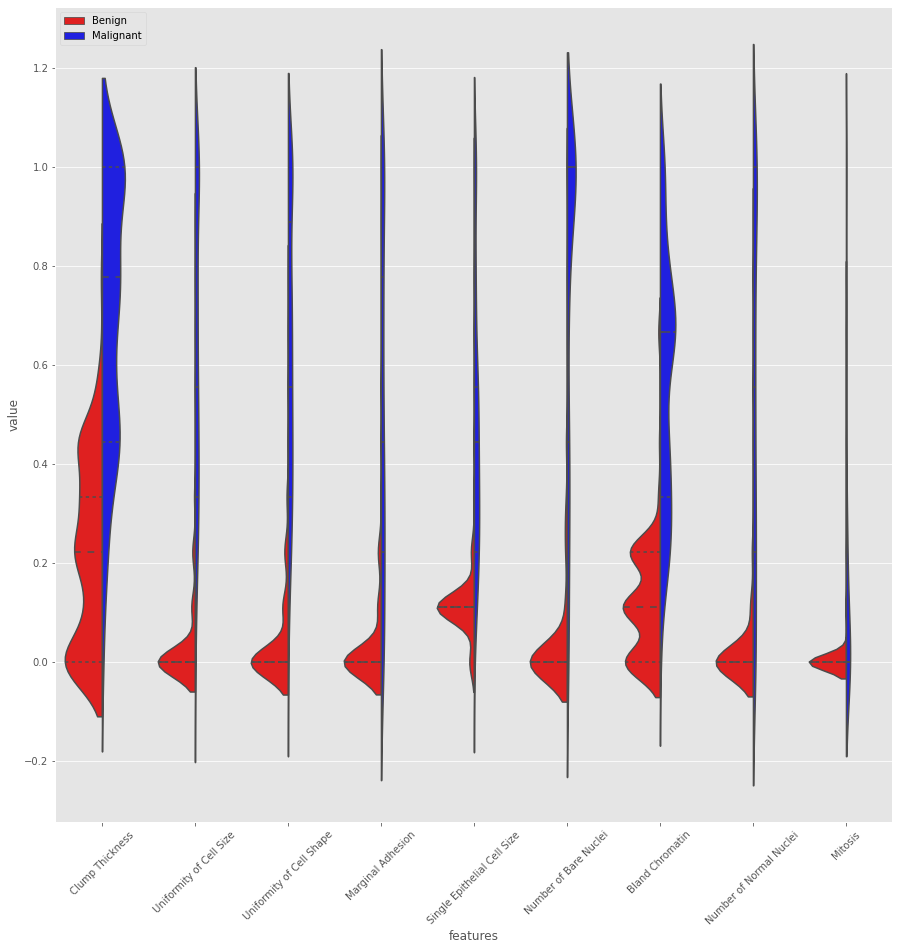

In [ ]:


data_box_plot = pd.melt(visual_data, "Diagnosis",
                    var_name="features") 

fig = plt.figure(figsize=(15,15))
print('violinplot')
my_pal = {'Benign':'r', 'Malignant':'b'}
sns.violinplot(x="features", y="value", hue="Diagnosis", data=data_box_plot, palette=my_pal, split=True, inner = 'quart')
plt.legend(loc='upper left') 
plt.xticks(rotation=45)
# plt.show()

boxenplot


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

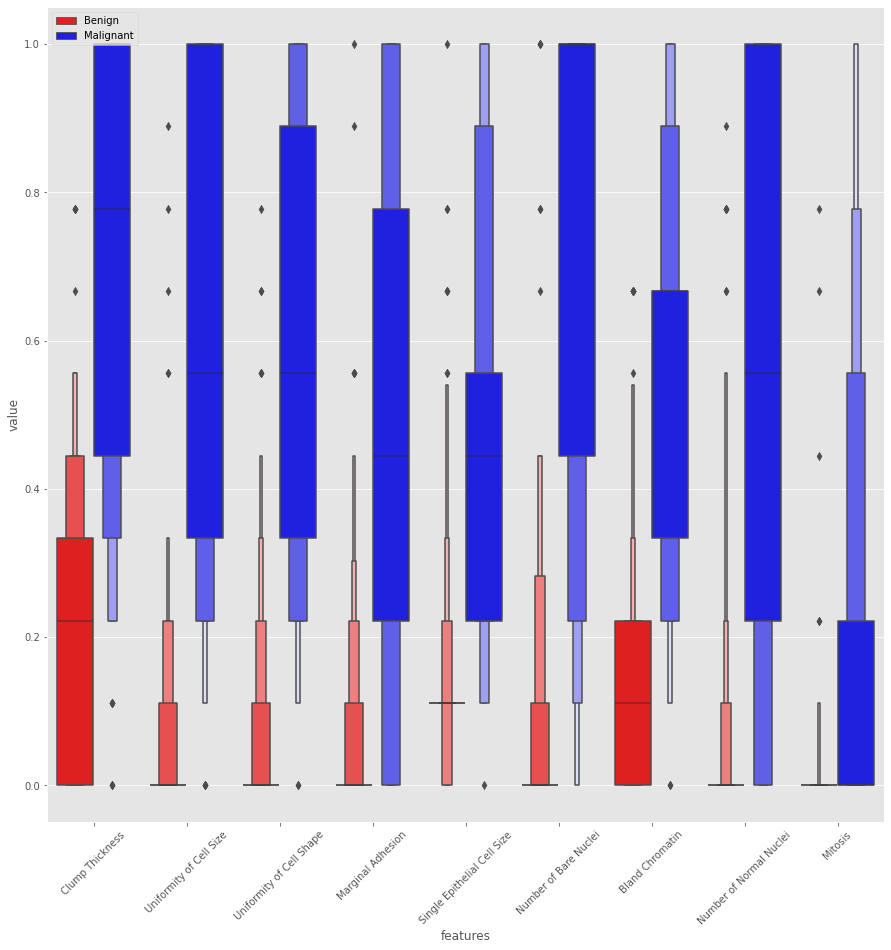

In [ ]:

data_box_plot = pd.melt(visual_data, "Diagnosis",
                    var_name="features") 

fig = plt.figure(figsize=(15,15))
print('boxenplot')
my_pal = {'Benign':'r', 'Malignant':'b'}
sns.boxenplot(x="features", y="value", hue="Diagnosis", data=data_box_plot, palette=my_pal, linewidth=1.5)
plt.legend(loc='upper left') 
plt.xticks(rotation=45)
# plt.show()

In [ ]:
print('Number of data samples that are outlier for class Benign: %d' % len(data[(data['Bland Chromatin']>0.5) & (data['Diagnosis'] == 1)]))
print('Number of data samples that are outlier for class Malignant: %d' % len(data[(data['Clump Thickness']<0.15) & (data['Diagnosis'] == 0)]))


Number of data samples that are outlier for class Benign: 8
Number of data samples that are outlier for class Malignant: 7


### Simply visualizing the plots for this small dataset is not helping us to detect outlier. Rather, its creating more confusion that whether or not to remore some samples, like above mentioned for Malignant.

In [ ]:
data[(data['Clump Thickness']<0.15) & (data['Diagnosis'] == 0)]

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Number of Bare Nuclei,Bland Chromatin,Number of Normal Nuclei,Mitosis,Diagnosis
39,0.111111,0.444444,0.222222,0.222222,0.555556,0.666667,0.666667,0.444444,0.000000,0
101,0.111111,0.222222,0.333333,0.333333,0.111111,0.444444,0.111111,0.444444,0.000000,0
107,0.000000,0.555556,0.777778,1.000000,0.777778,1.000000,0.444444,0.666667,0.000000,0
186,0.000000,0.444444,0.777778,0.555556,0.444444,0.777778,0.666667,1.000000,0.000000,0
282,0.000000,0.333333,0.222222,1.000000,0.333333,1.000000,0.444444,0.555556,0.000000,0
353,0.111111,0.666667,1.000000,1.000000,0.666667,1.000000,0.333333,0.888889,0.333333,0
591,0.111111,0.444444,0.666667,0.555556,0.333333,1.000000,0.666667,0.555556,0.000000,0


#### we can see above, outlier for 'Clump Thickness' is almost whole mean range for 'Number of Normal Nuclei' feature in Malignant class

## Handle Outlier
### Let's instead use Normal Distribution and Z-Score to detect and handle outlier

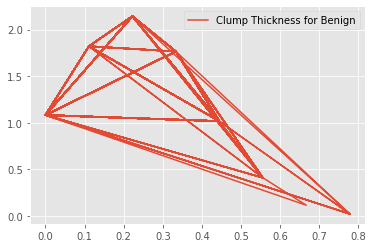

In [ ]:
data_ct_benign = data[data['Diagnosis'] == 1]['Clump Thickness']

mean = statistics.mean(data_ct_benign)
sd = statistics.stdev(data_ct_benign)
  
plt.plot(data_ct_benign, norm.pdf(data_ct_benign, mean, sd))
plt.legend(labels=['Clump Thickness for Benign'])
plt.show()

In [ ]:
z = np.abs(stats.zscore(data))
print(len(np.where(z > 3)[0]))

62


#### Z-Score greater than 3 and less than -3 are mostly outliers in case of normal distribution as it constituent less than 2% of samples that are fartest from Mean and SD

In [ ]:
# Quartile 1 and 3 differences for all features
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Clump Thickness                0.444444
Uniformity of Cell Size        0.444444
Uniformity of Cell Shape       0.444444
Marginal Adhesion              0.333333
Single Epithelial Cell Size    0.222222
Number of Bare Nuclei          0.444444
Bland Chromatin                0.333333
Number of Normal Nuclei        0.333333
Mitosis                        0.000000
Diagnosis                      1.000000
dtype: float64


In [ ]:
data_remove_outlier = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_remove_outlier.shape

(504, 10)

In [ ]:
# data = data_remove_outlier.copy()

# Feature Analysis

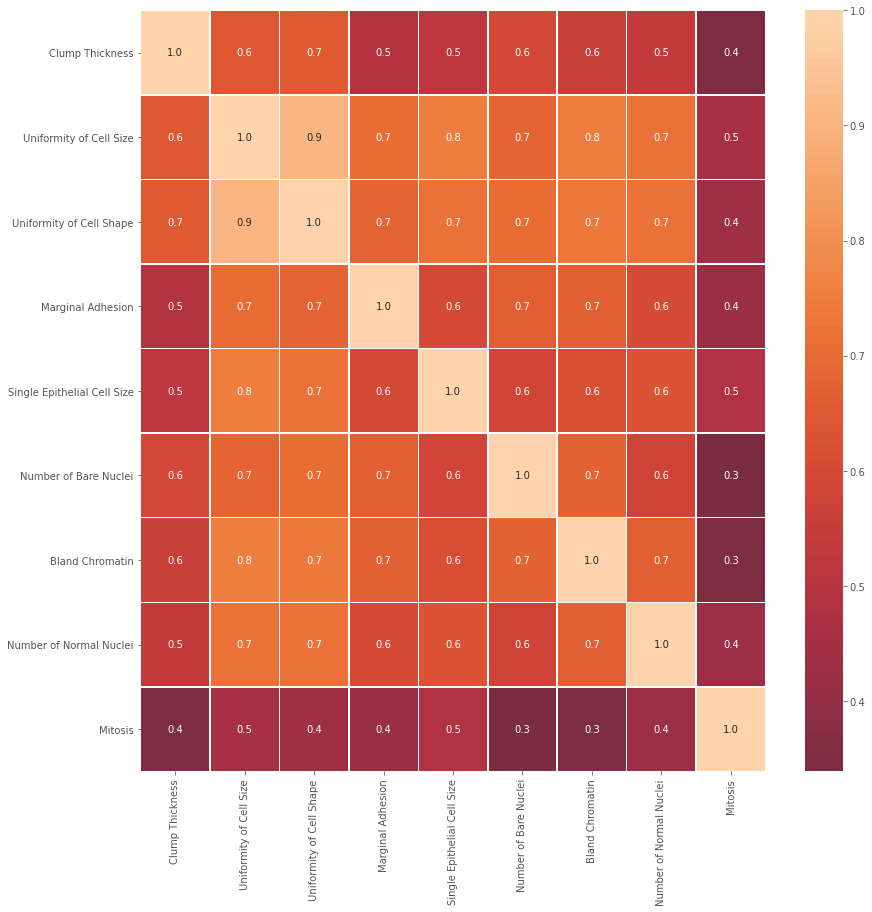

In [ ]:
#Correlation Analysis - Generation of a heap map plot for all features
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(data.iloc[:,:-1].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,center=0)

In [ ]:
#Univariate Selection in Scikit - Select K Best class from Scikit that can be used to choose n best features
X = data.iloc[:,:-1]
y = data.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)

univs = SelectKBest(f_classif, k=4)
X_train_f = univs.fit_transform(X_train, y_train)
a = univs.get_support()
b = X.columns.tolist()
for i in zip(a,b):
    print(i[1]+' -> '+str(i[0]))

Clump Thickness -> False
Uniformity of Cell Size -> True
Uniformity of Cell Shape -> True
Marginal Adhesion -> False
Single Epithelial Cell Size -> False
Number of Bare Nuclei -> True
Bland Chromatin -> True
Number of Normal Nuclei -> False
Mitosis -> False


Explained variation per principal component: [0.68879016 0.07274293] 



<Figure size 432x288 with 0 Axes>

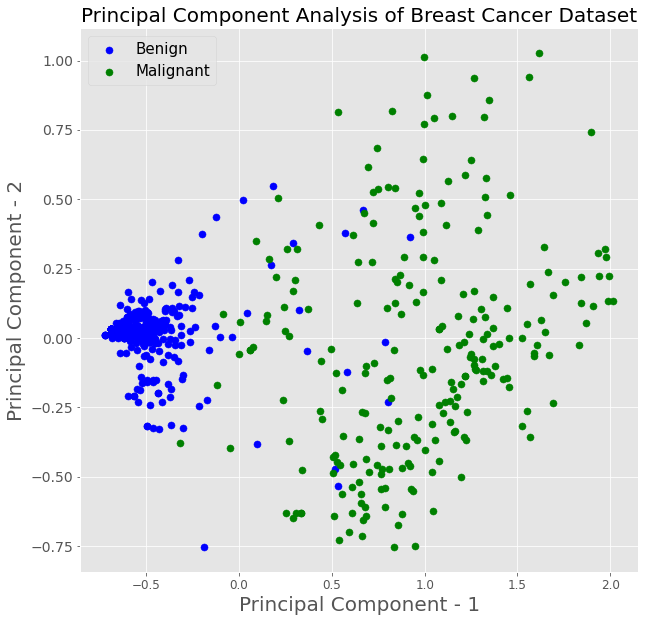

In [ ]:
#Principal Component Analysis (PCA) - Running PCA and plotting the PC1 and PC2 for two categories
pca_breast = PCA(n_components=2)
X_new = pca_breast.fit_transform(X)
principal_df = pd.DataFrame(data = X_new, columns = ['principal component 1', 'principal component 2'])
print('Explained variation per principal component: {}'.format(pca_breast.explained_variance_ratio_),"\n")
# principal component 1 holds 68.9% of the information 
# while the principal component 2 holds only 7.3% of the information.
# 23.8% information was lost.

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = ['Benign','Malignant']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = visual_data['Diagnosis'] == target
    plt.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
               , principal_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
#Malignant class is spread out as compared to the Benign class.

#kNN MODEL

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state = 1)
Y_train = y_train.astype('int')
classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'euclidean')
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

[[ 53   4]
 [  1 117]]
Normalized confusion matrix
[[0.92982456 0.07017544]
 [0.00847458 0.99152542]]


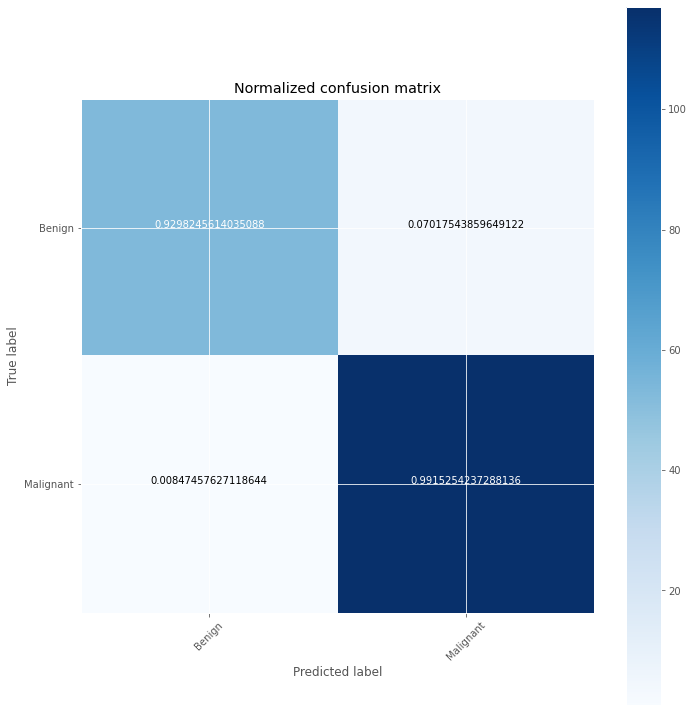

In [ ]:
#Making Prediction
y_predicted = classifier.predict(X_test)
#Forming the confusion matrix for KNN Model
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predicted)
print(confusion_matrix)
class_names = ['Benign','Malignant']
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize = True, title='Normalized confusion matrix')
plt.show()

In [ ]:
#Calculating the accuracy
print("Accuracy (in percentage) : %0.2f" %((metrics.accuracy_score(y_test, y_predicted))*100),"%")

Accuracy (in percentage) : 97.14 %




## Identifying the best number of neighbors



The optimal number of neighbors is 5.
Accuracy is 98.29 %


A plot that indicates k in x axis and accuracy in y axis.



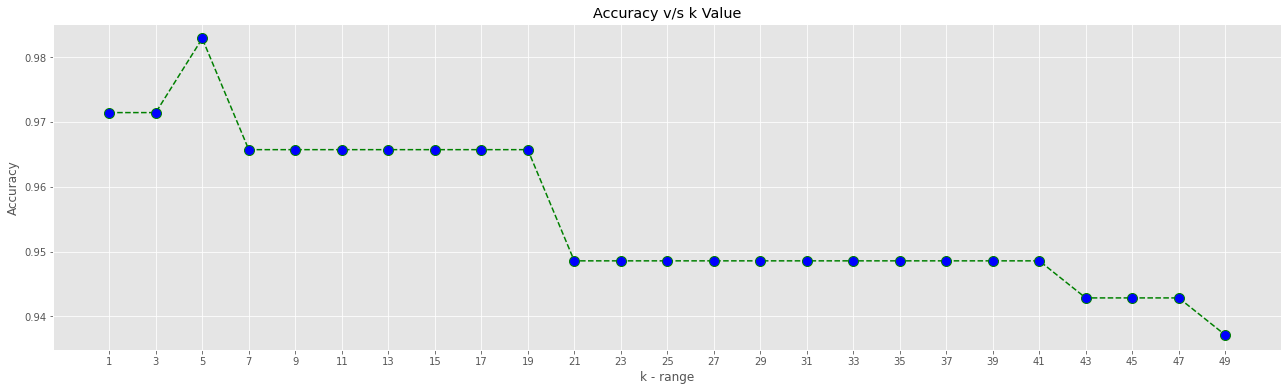

In [ ]:
#Creating list of k for kNN
k_list = list(range(1,50,2))
#Creating list of cv scores
scores = []
acc = []
#Performing 10-fold cross validation
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predict = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, predict))
    acc.append(metrics.accuracy_score(y_test, predict))
#Finding best k
#MSE: MEAN SQUARED ERROR
MSE = [1 - x for x in scores]
best_k = k_list[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d." % best_k)
print("Accuracy is %0.2f" % ((max(acc))*100), "%")
print("\n") 
plt.figure(figsize=(22,6))
plt.plot(range(1,50,2),acc,color = 'green',linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
plt.xticks(np.arange(min(k_list), max(k_list)+1, 2.0)) 
plt.title("Accuracy v/s k Value")
plt.xlabel("k - range")
plt.ylabel("Accuracy")
print("A plot that indicates k in x axis and accuracy in y axis.\n")

#SVM Model

In [ ]:
svm_data = data.copy()

svm_data.iloc[:,9].replace(1, 'Benign',inplace=True)
svm_data.iloc[:,9].replace(0, 'Malignant',inplace=True)

svm_X = svm_data.iloc[:,0:9]
svm_y = svm_data['Diagnosis']

class_names = list(svm_y.unique())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(svm_X, svm_y, test_size=0.25, random_state=1)

In [ ]:
svc = SVC(kernel = 'linear',C=.1, gamma=10, probability = True)
svc.fit(X,y) 
y_pred = svc.fit(X_train, y_train).predict(X_test)
t = pd.DataFrame(svc.predict_proba(X_test))
svc.score(X_train,y_train), svc.score(X_test, y_test)

(0.9637404580152672, 0.96)

Normalized confusion matrix
[[0.99 0.01]
 [0.11 0.89]]


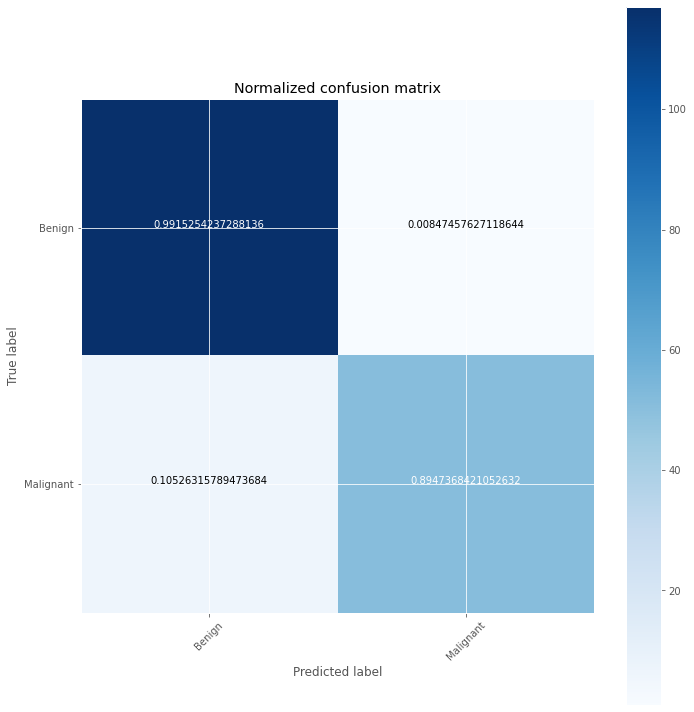

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision = 2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize = True, title='Normalized confusion matrix')
plt.show()

# EVALUATION OF THE TWO MODELS (kNN and SVM) on the given dataset

In [ ]:
# Create X and y datasets
X = np.array(data.drop(['Diagnosis'], 1))
y = np.array(data['Diagnosis'])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state=42)

In [ ]:
# Define the models to train
from sklearn.metrics import classification_report, accuracy_score

models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=best_k)))
models.append(('SVM', SVC()))

# Evaluate each model
results = []
names = []
for name, model in models:
    print('Method: {}'.format(name))
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))


Method: KNN
KNN
0.9783549783549783
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        77
           1       0.98      0.99      0.98       154

    accuracy                           0.98       231
   macro avg       0.98      0.97      0.98       231
weighted avg       0.98      0.98      0.98       231

Method: SVM
SVM
0.9653679653679653
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        77
           1       0.97      0.98      0.97       154

    accuracy                           0.97       231
   macro avg       0.96      0.96      0.96       231
weighted avg       0.97      0.97      0.97       231



### Our evaluated best k for KNN gives better results than SVM

### Below is the verification of both the trained models by simply testing a random sample and getting the prediction.

In [1]:
# last element is mitosis, higher the mitosis higher the likeyhood of cancer
example = np.array([[0.6, 0.1, 0.0, 0.2, 0.0, 0.33, 0.6, 0.0, 0.003]])

# reshape example to make it a column vector
example = example.reshape(len(example), -1)
for name, model in models:
    prediction = model.predict(example)
    if prediction == 1:
        result = 'benign'
    else:
        result = 'malignant'       
    print(name)
    print('The cancer is ' + result)

NameError: ignored

### Therefore, we can see both the models gave same results